In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms
data_path = './dataset_CIFAR10'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [7]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [8]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [9]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [10]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [11]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [12]:
conv = nn.Conv2d(3, 16, kernel_size=5) # <1>
conv

Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))

In [13]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 5, 5]), torch.Size([16]))

In [14]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 28, 28]))

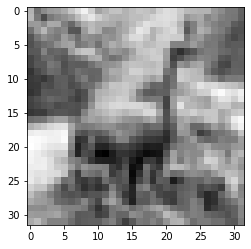

In [15]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

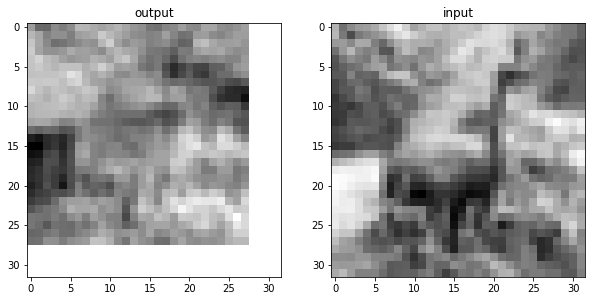

In [16]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

In [29]:
conv = nn.Conv2d(3, 1, kernel_size=5, padding=2) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [30]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

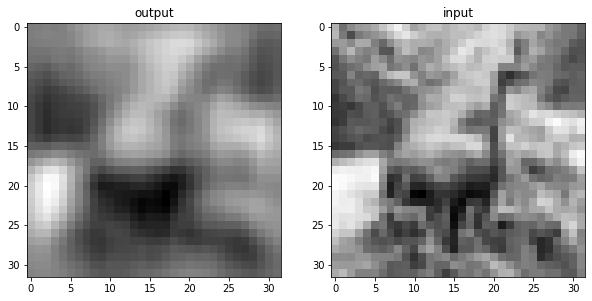

In [31]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [32]:
conv = nn.Conv2d(3, 1, kernel_size=5, padding=2)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0,-1.0, 0.0],
                                   [-1.0, 0.0, 1.0,-1.0, 0.0],
                                   [-1.0, 0.0, 1.0,-1.0, 0.0],
                                   [-1.0, 0.0, 1.0,-1.0, 0.0],
                                   [-1.0, 0.0, 1.0,-1.0, 0.0]])
    conv.bias.zero_()

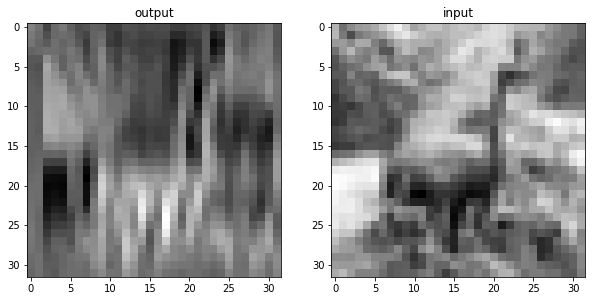

In [33]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

In [47]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [43]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [54]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [55]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18858, [1200, 16, 1152, 8, 16384, 32, 64, 2])

In [56]:
model(img.unsqueeze(0))

RuntimeError: size mismatch, m1: [64 x 8], m2: [512 x 32] at ..\aten\src\TH/generic/THTensorMath.cpp:41

In [57]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [58]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18858, [1200, 16, 1152, 8, 16384, 32, 64, 2])

In [59]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [60]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1004, -0.1031]], grad_fn=<AddmmBackward>)

In [61]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [62]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-01 14:53:56.051619 Epoch 1, Training loss 0.5868153503745984
2020-12-01 14:55:31.781042 Epoch 10, Training loss 0.3332379293289913
2020-12-01 14:57:21.116531 Epoch 20, Training loss 0.2869916376034925
2020-12-01 14:59:09.130421 Epoch 30, Training loss 0.2626184722895076
2020-12-01 15:00:58.268130 Epoch 40, Training loss 0.24354392731455482
2020-12-01 15:02:46.363963 Epoch 50, Training loss 0.22409959611999
2020-12-01 15:04:34.341943 Epoch 60, Training loss 0.20775523117393446
2020-12-01 15:06:21.891956 Epoch 70, Training loss 0.1925284251285966
2020-12-01 15:08:09.663086 Epoch 80, Training loss 0.17470359550729678
2020-12-01 15:09:57.717273 Epoch 90, Training loss 0.1604555357888246
2020-12-01 15:11:46.045170 Epoch 100, Training loss 0.14534647881415239


In [63]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.87


In [64]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [65]:
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [66]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [67]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [68]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


2020-12-01 15:14:46.585807 Epoch 1, Training loss 0.5704766728316143
2020-12-01 15:16:23.776098 Epoch 10, Training loss 0.3280524134066454
2020-12-01 15:18:11.092413 Epoch 20, Training loss 0.2828038147870143
2020-12-01 15:19:58.834577 Epoch 30, Training loss 0.2530405694606957
2020-12-01 15:21:46.799193 Epoch 40, Training loss 0.23468478384670938
2020-12-01 15:23:34.811620 Epoch 50, Training loss 0.2162895821936571
2020-12-01 15:25:22.936876 Epoch 60, Training loss 0.20010788226203555
2020-12-01 15:27:10.185247 Epoch 70, Training loss 0.18284303936988686
2020-12-01 15:28:57.957266 Epoch 80, Training loss 0.16669270030821964
2020-12-01 15:30:45.900860 Epoch 90, Training loss 0.1534178585146263
2020-12-01 15:32:33.710257 Epoch 100, Training loss 0.1393590535327887


In [69]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.91
Accuracy val: 0.87


In [70]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

In [72]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [73]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2020-12-01 15:44:04.868895 Epoch 1, Training loss 0.5460123381796916
2020-12-01 15:45:53.282781 Epoch 10, Training loss 0.3162599285696722
2020-12-01 15:47:36.194418 Epoch 20, Training loss 0.2810005405146605
2020-12-01 15:49:18.943496 Epoch 30, Training loss 0.2462780362671348
2020-12-01 15:51:02.066570 Epoch 40, Training loss 0.2143521036976462
2020-12-01 15:52:47.610990 Epoch 50, Training loss 0.18404735041082285
2020-12-01 15:54:30.854745 Epoch 60, Training loss 0.1555400611298859
2020-12-01 15:56:13.417318 Epoch 70, Training loss 0.1292445258634865
2020-12-01 15:57:56.638133 Epoch 80, Training loss 0.1053341547869573
2020-12-01 15:59:39.536809 Epoch 90, Training loss 0.0844827075103286
2020-12-01 16:01:22.949112 Epoch 100, Training loss 0.06674723585794685
Accuracy train: 0.97
Accuracy val: 0.90


{'train': 0.9745, 'val': 0.9025}

In [74]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [75]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2020-12-01 16:01:52.684794 Epoch 1, Training loss 0.5530916353699508
2020-12-01 16:03:24.431310 Epoch 10, Training loss 0.3194962391617951
2020-12-01 16:05:06.449319 Epoch 20, Training loss 0.2820548973265727
2020-12-01 16:06:49.844667 Epoch 30, Training loss 0.2512473791932604
2020-12-01 16:08:33.459024 Epoch 40, Training loss 0.2226663100871311
2020-12-01 16:10:15.772265 Epoch 50, Training loss 0.19488366280391717
2020-12-01 16:11:59.001058 Epoch 60, Training loss 0.16831824088552197
2020-12-01 16:13:41.574610 Epoch 70, Training loss 0.14288891097352763
2020-12-01 16:15:23.450018 Epoch 80, Training loss 0.11894941697739492
2020-12-01 16:17:05.414192 Epoch 90, Training loss 0.09697372815126826
2020-12-01 16:18:47.592795 Epoch 100, Training loss 0.07729493175295128
Accuracy train: 0.96
Accuracy val: 0.90


In [76]:
sum(p.numel() for p in model.parameters())

39922

In [77]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [78]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2020-12-01 16:22:26.622226 Epoch 1, Training loss 0.5940999420964794
2020-12-01 16:23:17.363461 Epoch 10, Training loss 0.354188285151105
2020-12-01 16:24:13.772528 Epoch 20, Training loss 0.32138586291082344
2020-12-01 16:25:07.557616 Epoch 30, Training loss 0.298088148046451
2020-12-01 16:26:01.420499 Epoch 40, Training loss 0.2805733453885765
2020-12-01 16:26:55.384106 Epoch 50, Training loss 0.2661852066873745
2020-12-01 16:27:49.570121 Epoch 60, Training loss 0.2529787028291423
2020-12-01 16:28:44.097224 Epoch 70, Training loss 0.2404922664070585
2020-12-01 16:29:37.950137 Epoch 80, Training loss 0.22897696756063754
2020-12-01 16:30:31.778105 Epoch 90, Training loss 0.21807555232647877
2020-12-01 16:31:27.109737 Epoch 100, Training loss 0.20791862027090827
Accuracy train: 0.90
Accuracy val: 0.87


In [79]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=5, padding=2)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [80]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2020-12-01 16:32:03.189882 Epoch 1, Training loss 0.5797534190165768
2020-12-01 16:33:41.117075 Epoch 10, Training loss 0.37840440129018893
2020-12-01 16:35:30.181777 Epoch 20, Training loss 0.3454028598632023
2020-12-01 16:37:26.146492 Epoch 30, Training loss 0.3247683668022702
2020-12-01 16:39:15.816053 Epoch 40, Training loss 0.3085335561424304
2020-12-01 16:41:09.453504 Epoch 50, Training loss 0.29648859248419474
2020-12-01 16:43:02.883917 Epoch 60, Training loss 0.28413291645657485
2020-12-01 16:44:52.926625 Epoch 70, Training loss 0.2712617321948337
2020-12-01 16:46:40.182641 Epoch 80, Training loss 0.2603281271305813
2020-12-01 16:48:31.287381 Epoch 90, Training loss 0.2485915531588208
2020-12-01 16:50:25.365154 Epoch 100, Training loss 0.2364640794457144
Accuracy train: 0.90
Accuracy val: 0.87


In [81]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=5, padding=2)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [82]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)


2020-12-01 16:51:40.804984 Epoch 1, Training loss 0.45743362292362627
2020-12-01 16:53:52.081727 Epoch 10, Training loss 0.26387193362424327
2020-12-01 16:56:12.666569 Epoch 20, Training loss 0.1925089537717734
2020-12-01 16:58:32.675949 Epoch 30, Training loss 0.1373313061987898
2020-12-01 17:00:51.768315 Epoch 40, Training loss 0.09137180725195605
2020-12-01 17:03:11.647039 Epoch 50, Training loss 0.056529859098706656
2020-12-01 17:06:06.502247 Epoch 60, Training loss 0.03268600749682374
2020-12-01 17:10:49.235722 Epoch 70, Training loss 0.021110546386616816
2020-12-01 17:15:25.480799 Epoch 80, Training loss 0.011024518690374532
2020-12-01 17:19:53.833609 Epoch 90, Training loss 0.006971164075598405
2020-12-01 17:24:23.572352 Epoch 100, Training loss 0.004616577008436582
Accuracy train: 0.99
Accuracy val: 0.89


In [88]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [89]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2020-12-01 17:38:26.757319 Epoch 1, Training loss 0.6920757939101784
2020-12-01 17:41:57.512261 Epoch 10, Training loss 0.3462593044824661
2020-12-01 17:45:53.030465 Epoch 20, Training loss 0.30241088502725977
2020-12-01 17:49:48.567339 Epoch 30, Training loss 0.2700205162452285
2020-12-01 17:53:43.363861 Epoch 40, Training loss 0.23971227988315996
2020-12-01 17:57:38.361325 Epoch 50, Training loss 0.2113032682686095
2020-12-01 18:01:34.227326 Epoch 60, Training loss 0.18319089331065014
2020-12-01 18:05:31.350359 Epoch 70, Training loss 0.15321147956760825
2020-12-01 18:09:28.315195 Epoch 80, Training loss 0.12389891623121918
2020-12-01 18:13:26.073017 Epoch 90, Training loss 0.09634969932780524
2020-12-01 18:17:25.335656 Epoch 100, Training loss 0.0709884492265191
Accuracy train: 0.95
Accuracy val: 0.89
